In [6]:
from goes2go import GOES
import time
from datetime import datetime, timedelta
import os

In [2]:
def goes_get(start_date, end_date, save_path, satellite_name, product_name, domain_name, bands_name):
    """
    Retrieves GOES satellite data for the specified parameters and saves it to the given path.
    
    Parameters:
    start_date (str): The start date for data retrieval in 'YYYY-MM-DD HH:MM:SS' format.
    end_date (str): The end date for data retrieval in 'YYYY-MM-DD HH:MM:SS' format.
    save_path (str): The directory path where the data will be saved.
    satellite_name (str): The name of the satellite.
    product_name (str): The product name to retrieve.
    domain_name (str): The domain name for the data.
    bands_name (list): The list of band names to retrieve.
    
    Returns:
    dict: Information about the retrieved data.
    """
    
    # Record the start time to measure the execution time of the script
    start_time = time.time()
    
    # Initialize a GOES object with the specified parameters
    G = GOES(satellite=satellite_name, product=product_name, domain=domain_name, bands=bands_name)
    
    # Ensure the directory exists before saving the data
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Retrieve data within the specified date range and save it to the specified directory
    data_info = G.timerange(start=start_date, end=end_date, save_dir=save_path)
    
    # Calculate and print the total run time of the script in hours and minutes
    elapsed_time = time.time() - start_time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes = remainder // 60
    print(f"Run Time: {int(hours)} hours, {int(minutes)} minutes")
    
    # Return the data information retrieved by the GOES object
    return data_info

In [9]:
# Define the start and end dates for the data retrieval
start_date = '2022-12-27'
end_date = '2022-12-28'
save_path = 'output'
satellite_name = 'goes17'
product_name = 'ABI-L1b-RadF'
domain_name = 'C'
bands_name = list(range(1, 17))  # Bands from 1 to 16
specific_hours = ['00', '06', '12', '18']  # Specific hours to download data

# Convert start and end dates to datetime objects
start_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_dt = datetime.strptime(end_date, '%Y-%m-%d')

# Loop through each band and each specific hour to call goes_get function to retrieve data
for hour in specific_hours:
    time_str = f"{hour}:00:00"
    start_time = datetime.combine(start_dt, datetime.strptime(time_str, '%H:%M:%S').time())
    end_time = start_time + timedelta(minutes=20)

    band_save_path = f"{save_path}/"  # Example path for demonstration
    os.makedirs(os.path.dirname(band_save_path), exist_ok=True)  # Create the directory if it doesn't exist

    data_information = goes_get(
        start_time.strftime('%Y-%m-%d %H:%M:%S'),
        end_time.strftime('%Y-%m-%d %H:%M:%S'),
        band_save_path,
        satellite_name,
        product_name,
        domain_name,
        [1]
    )
    
    # Optionally, use data_information as needed
    #print(f"Data retrieval for band {band} at {hour} hour completed successfully.")

📦 Finished downloading [2] files to [output/noaa-goes17/ABI-L1b-RadF].
Run Time: 0 hours, 0 minutes
📦 Finished downloading [2] files to [output/noaa-goes17/ABI-L1b-RadF].
Run Time: 0 hours, 0 minutes
📦 Finished downloading [2] files to [output/noaa-goes17/ABI-L1b-RadF].
Run Time: 0 hours, 0 minutes
📦 Finished downloading [2] files to [output/noaa-goes17/ABI-L1b-RadF].
Run Time: 0 hours, 0 minutes


In [18]:
filename = 'output/noaa-goes17/ABI-L1b-RadF/2022/361/00/OR_ABI-L1b-RadF-M6C01_G17_s20223610000320_e20223610009386_c20223610009429.nc'

In [20]:
import xarray as xr

In [22]:
ds = xr.open_dataset(filename)

In [23]:
print(ds)

<xarray.Dataset>
Dimensions:                                           (y: 10848, x: 10848,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1519 ... ...
  * x                                                 (x) float64 -0.1519 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[n

In [1]:
import GOES
import pyproj as pyproj
from pyresample import utils
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import numpy as np
import concurrent.futures

import datetime
import matplotlib.pyplot as plt

In [4]:
def goes_reproject(filename, domain, var):
  ds = GOES.open_dataset(filename)
  CMI, LonCen, LatCen = ds.image(var, lonlat='center', domain=domain)
  sat = ds.attribute('platform_ID')
  band = ds.variable('band_id').data[0]
  wl = ds.variable('band_wavelength').data[0]
  standard_name = CMI.standard_name
  units = CMI.units
  time_bounds = CMI.time_bounds
  LonCenCyl, LatCenCyl = GOES.create_gridmap(domain, PixResol=2.0)
  LonCorCyl, LatCorCyl = GOES.calculate_corners(LonCenCyl, LatCenCyl)
  Prj = pyproj.Proj('+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km')
  AreaID = 'cyl'
  AreaName = 'cyl'
  ProjID = 'cyl'
  Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'

  ny, nx = LonCenCyl.data.shape
  SW = Prj(LonCenCyl.data.min(), LatCenCyl.data.min())
  NE = Prj(LonCenCyl.data.max(), LatCenCyl.data.max())
  area_extent = [SW[0], SW[1], NE[0], NE[1]]
  AreaDef = utils.get_area_def(AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)

  SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
  CMICyl = resample_nearest(SwathDef, CMI.data, AreaDef, radius_of_influence=6000,
                            fill_value=np.nan, epsilon=3, reduce_data=True)
  del CMI, LonCen, LatCen, SwathDef, LonCenCyl, LatCenCyl

  return LatCorCyl.data, LonCorCyl.data, CMICyl.data

In [7]:
# Define the domain and the list of file paths
domain = [-180, -90, 0, 80]
filepaths = ['output/noaa-goes17/ABI-L1b-RadF/2022/361/06/OR_ABI-L1b-RadF-M6C01_G17_s20223610600320_e20223610609387_c20223610609439.nc']  # Replace with your actual file paths

# Function to process each file
def process_file(filepath):
  t1 = datetime.datetime.now()
  LatCorCyl, LonCorCyl, CMICyl = goes_reproject(filepath, domain, 'Rad')
  print(f'Processing {filepath} took {datetime.datetime.now() - t1} sec')
  return LatCorCyl, LonCorCyl, CMICyl

lat, lon, data = process_file(filepaths[0])

Processing output/noaa-goes17/ABI-L1b-RadF/2022/361/06/OR_ABI-L1b-RadF-M6C01_G17_s20223610600320_e20223610609387_c20223610609439.nc took 0:00:25.284233 sec


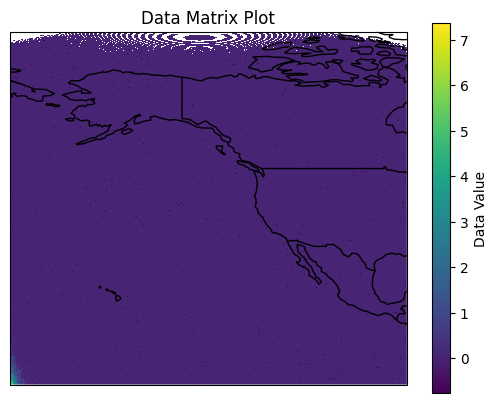

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
mesh = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='viridis')

# Add coastlines and gridlines
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

ax.set_xlim(domain[0], domain[1])
ax.set_ylim(domain[2], domain[3])

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Data Value')

# Set the title
plt.title('Data Matrix Plot')

# Show the plot
plt.show()